# Retail Sales: Clothing and Clothing Accessory Stores
## Importing Datasets
Import dataset from here
https://fred.stlouisfed.org/series/MRTSSM448USN?utm_source=series_page&utm_medium=related_content&utm_term=other_formats&utm_campaign=other_format


In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv('./MRTSSM448USN.csv')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DATE          338 non-null    object
 1   MRTSSM448USN  338 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.4+ KB


In [0]:
df.describe()

,MRTSSM448USN
count,338.000000
mean,16417.878698
std,5460.078890
min,6938.000000
25%,12354.750000
50%,15896.500000
75%,19818.500000
max,35267.000000


In [0]:
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df.columns = ['Sales']
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-10-01,21369
2019-11-01,25169
2019-12-01,35267


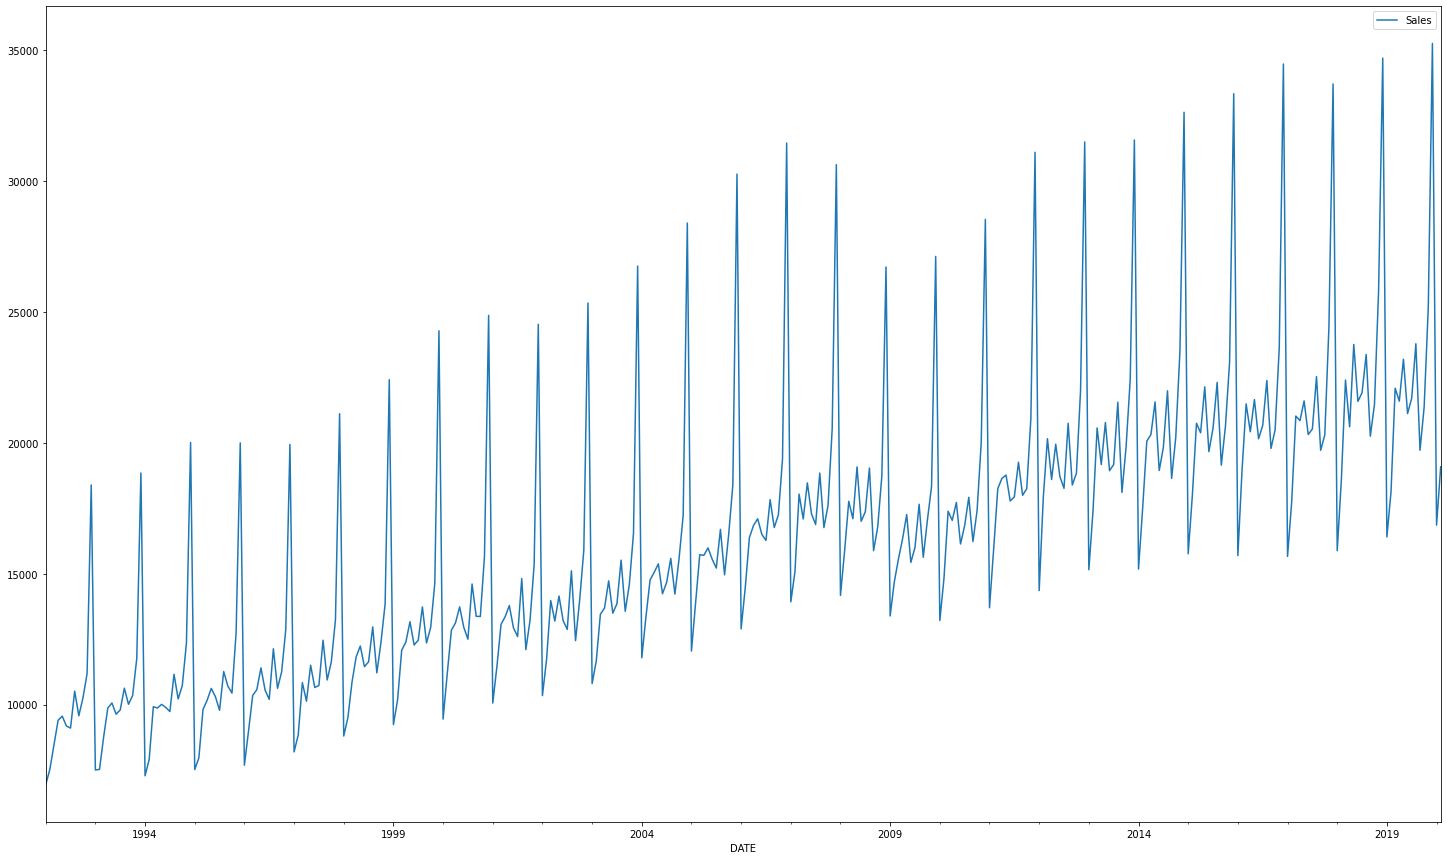

In [0]:
df.plot(figsize=[25,15])

In [0]:
test_size = 18 
test_ind = len(df) - test_size

In [0]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [0]:
test

,Sales
DATE,
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410
2019-02-01,18134
2019-03-01,22093
2019-04-01,21597
2019-05-01,23200


In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [0]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
val_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [0]:
X,y = generator[0]
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [0]:
y

array([[0.02047633]])

In [0]:
from tensorflow.keras.callbacks import EarlyStopping 

In [0]:
early_stop = EarlyStopping('val_loss', patience=2)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN

In [0]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [0]:
model.fit_generator(generator=generator, epochs=20, validation_data=val_generator, callbacks=[early_stop])

Epoch 1/20
326/326 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 2/20
326/326 [==============================] - 2s 5ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 3/20
326/326 [==============================] - 2s 5ms/step - loss: 0.0015 - val_loss: 8.8509e-04
Epoch 4/20
326/326 [==============================] - 2s 5ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 5/20
326/326 [==============================] - 2s 5ms/step - loss: 0.0014 - val_loss: 0.0019


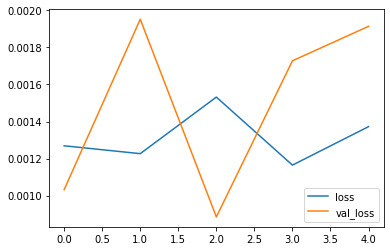

In [0]:
pd.DataFrame(model.history.history).plot()

In [0]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1,length,1))

In [0]:
predictions = []
curr_batch = first_eval_batch
for i in range(len(test)):
  curr_pred = model.predict(curr_batch)[0]
  curr_batch = curr_batch[:,1:,:]
  curr_batch = np.append(curr_batch,[[curr_pred]], axis=1)
  predictions.append(curr_pred)

In [0]:
predictions = scaler.inverse_transform(predictions)

In [0]:
predictions

array([[19368.94362617],
       [19789.01253843],
       [23182.36929178],
       [31716.51752853],
       [16334.47760057],
       [18193.83045101],
       [21294.75370932],
       [19883.88436508],
       [22470.55395699],
       [20731.35917187],
       [21002.27917051],
       [22191.43177366],
       [19034.27528286],
       [19335.90668416],
       [22094.43716383],
       [29676.89884949],
       [16490.15493441],
       [17885.96614456]])

In [0]:
test['prediction'] = predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


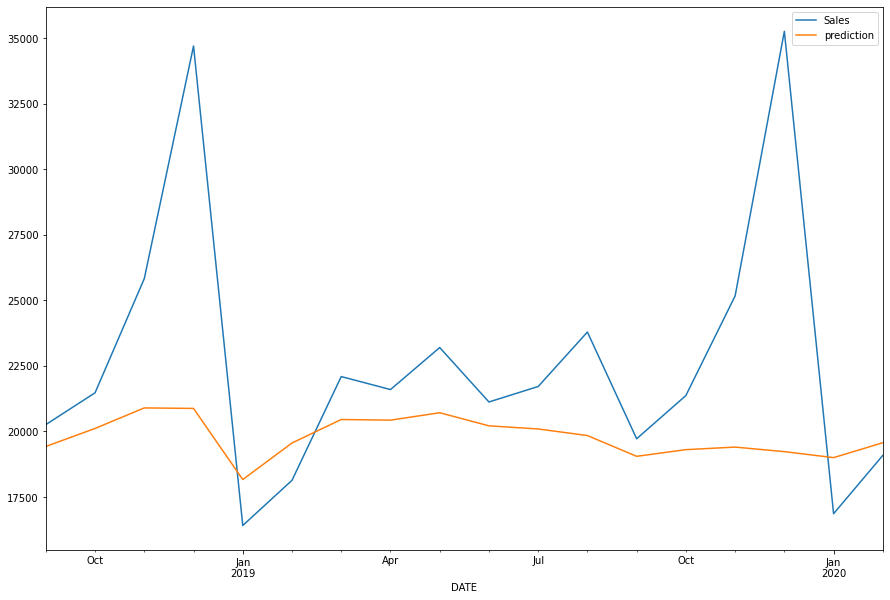

In [0]:
test.plot(figsize=[15,10])

In [0]:
model = Sequential()

model.add(SimpleRNN(12, activation='relu', input_shape=(length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [0]:
model.fit_generator(generator=generator, epochs=20, validation_data=val_generator, callbacks=[early_stop])

Epoch 1/20
326/326 [==============================] - 1s 3ms/step - loss: 0.1362 - val_loss: 0.0909
Epoch 2/20
326/326 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0734
Epoch 3/20
326/326 [==============================] - 1s 2ms/step - loss: 0.0236 - val_loss: 0.0568
Epoch 4/20
326/326 [==============================] - 1s 3ms/step - loss: 0.0220 - val_loss: 0.0615
Epoch 5/20
326/326 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0526
Epoch 6/20
326/326 [==============================] - 1s 3ms/step - loss: 0.0195 - val_loss: 0.0515
Epoch 7/20
326/326 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0483
Epoch 8/20
326/326 [==============================] - 1s 3ms/step - loss: 0.0168 - val_loss: 0.0442
Epoch 9/20
326/326 [==============================] - 1s 2ms/step - loss: 0.0139 - val_loss: 0.0333
Epoch 10/20
326/326 [==============================] - 1s 3ms/step - loss: 0.0121 - val_loss: 0.0293

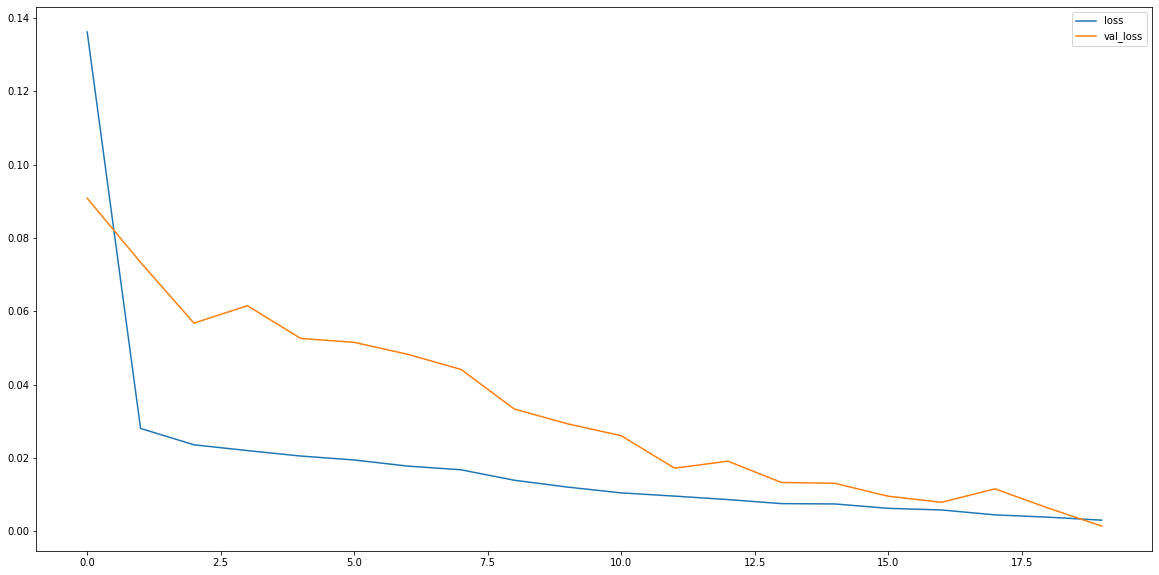

In [0]:
pd.DataFrame(model.history.history).plot(figsize=[20,10])

In [0]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1,length,1))

In [0]:
predictions = []
curr_batch = first_eval_batch
for i in range(len(test)):
  curr_pred = model.predict(curr_batch)[0]
  curr_batch = curr_batch[:,1:,:]
  curr_batch = np.append(curr_batch,[[curr_pred]], axis=1)
  predictions.append(curr_pred)

In [0]:
predictions = scaler.inverse_transform(predictions)

In [0]:
predictions

array([[ 22743.05331945],
       [ 25602.13197756],
       [ 24835.65784883],
       [ 32873.84808493],
       [ 26043.98937941],
       [ 28975.61370134],
       [ 37449.6443243 ],
       [ 44549.73513508],
       [ 45000.45798874],
       [ 45454.44792557],
       [ 53226.48744774],
       [ 61745.2705431 ],
       [ 69689.1323719 ],
       [ 75938.3499527 ],
       [ 83151.34721756],
       [ 91312.97409439],
       [ 99426.03799629],
       [107181.39733505]])

In [0]:
test['simple_prediction'] = predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


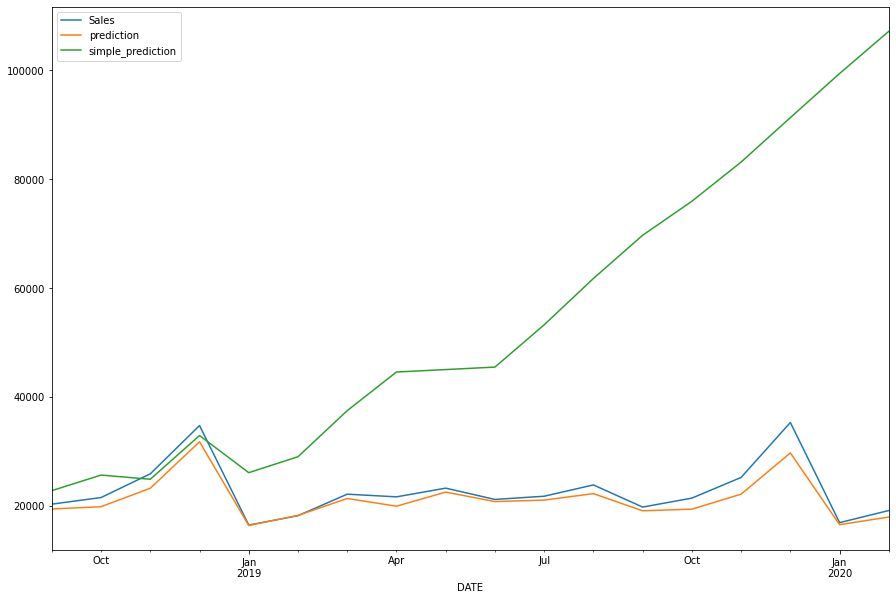

In [0]:
test.plot(figsize=[15,10])

In [0]:
full_scalar = MinMaxScaler()
scaled_full_data = full_scalar.fit_transform(df)

In [0]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [0]:
model = Sequential()

model.add(LSTM(100, input_shape=(length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [0]:
model.fit_generator(generator, epochs=20,
                   validation_data=val_generator)

Epoch 1/20
326/326 [==============================] - 2s 6ms/step - loss: 0.0083 - val_loss: 0.0177
Epoch 2/20
326/326 [==============================] - 2s 6ms/step - loss: 0.0058 - val_loss: 0.0099
Epoch 3/20
326/326 [==============================] - 2s 7ms/step - loss: 0.0060 - val_loss: 0.0185
Epoch 4/20
326/326 [==============================] - 2s 6ms/step - loss: 0.0053 - val_loss: 0.0098
Epoch 5/20
326/326 [==============================] - 2s 6ms/step - loss: 0.0035 - val_loss: 0.0069
Epoch 6/20
326/326 [==============================] - 2s 6ms/step - loss: 0.0035 - val_loss: 0.0076
Epoch 7/20
326/326 [==============================] - 2s 6ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 8/20
326/326 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 0.0055
Epoch 9/20
326/326 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 10/20
326/326 [==============================] - 2s 6ms/step - loss: 0.0023 - val_loss: 0.0050

In [0]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1,length,1))

In [0]:
forecast = []
curr_batch = first_eval_batch
for i in range(12):
  curr_pred = model.predict(curr_batch)[0]
  curr_batch = curr_batch[:,1:,:]
  curr_batch = np.append(curr_batch,[[curr_pred]], axis=1)
  forecast.append(curr_pred)

In [0]:
forecast = full_scalar.inverse_transform(forecast)

In [0]:
forecast

array([[20102.52636027],
       [21518.18139565],
       [28048.24842787],
       [34788.22124231],
       [16917.18348861],
       [19911.88766351],
       [23923.50828832],
       [22228.39650887],
       [25274.0363366 ],
       [22713.4397499 ],
       [22983.69057399],
       [23889.07051539]])

In [0]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-10-01,21369
2019-11-01,25169
2019-12-01,35267


In [0]:
forecaste_index = pd.date_range(start='2020-03-01', periods=12, freq='MS')
forecaste_index

DatetimeIndex(['2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01'],
              dtype='datetime64[ns]', freq='MS')

In [0]:
forecaste_df = pd.DataFrame(forecast, index=forecaste_index, columns=['Forecast'])

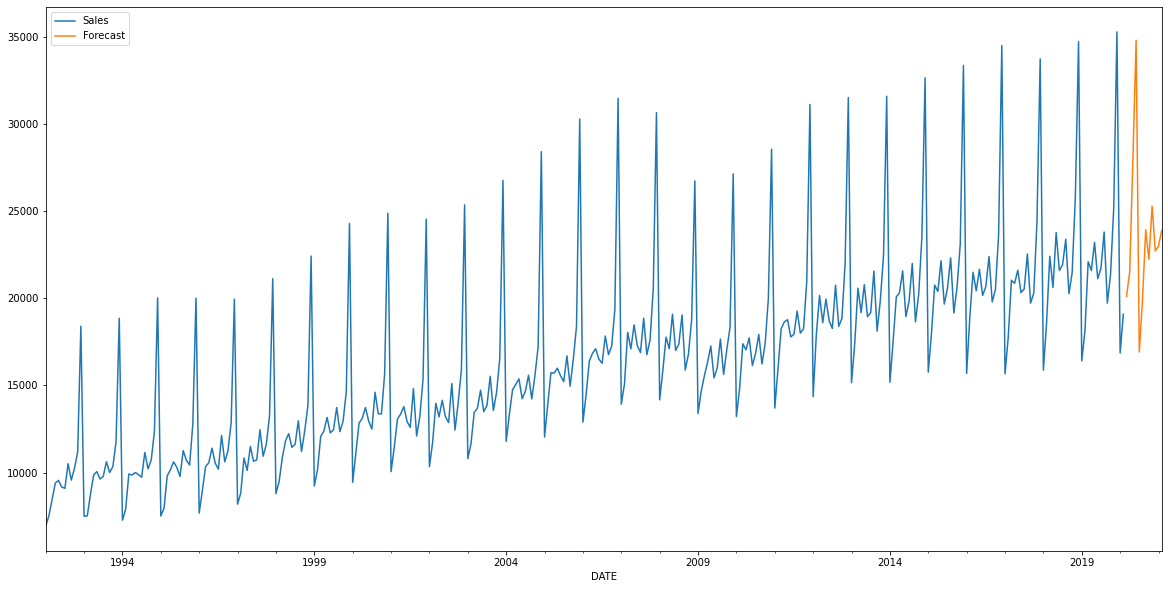

In [0]:
ax = df.plot()
forecaste_df.plot(ax=ax, figsize=[20,10])